# Apple length traj 300

I'm done with naming notebooks!!!

In [32]:
import numpy as np 
from matplotlib import pyplot as plt
from scipy.stats import uniform

np.random.seed(69696969)

# Data Generation from Stationary Cosine

Because this is the simplest case!

Text(0.5, 1.0, 'Position Profiles')

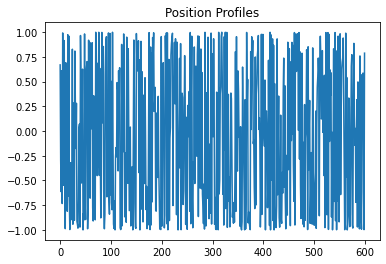

In [33]:
num_of_trajs = 200
length_of_trajs = 600
# v_profiles = np.zeros((num_of_trajs, length_of_trajs))
x_profiles = np.zeros((num_of_trajs, length_of_trajs))
t = np.arange(length_of_trajs)
for i in range(num_of_trajs):
    a_profile = uniform.rvs(loc=0, scale=2*np.pi, size=length_of_trajs)
    x_profiles[i,:] = np.cos(t + a_profile)
# Plot some sample v profiles and x profiles
trajs_to_plot = np.random.choice(num_of_trajs, 1)
plt.figure()
for i in trajs_to_plot:
    plt.plot(x_profiles[i,:])
plt.title('Position Profiles')

# Find the Numerical FPCA

And let's call this basis NECTARINE.

In [34]:
import skfda
from skfda.preprocessing.dim_reduction.projection import FPCA

Text(0.5, 1.0, 'Numerical FPCA basis of Position Profiles')

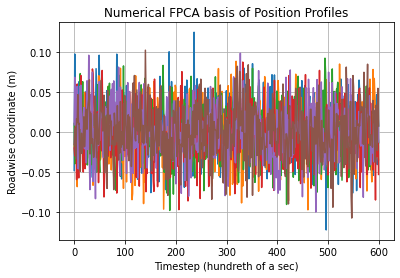

In [35]:
fdgrx = skfda.FDataGrid(x_profiles, np.arange(x_profiles.shape[1]))
#fdgrv = skfda.FDataGrid(x_profiles, np.arange(x_profiles.shape[1]))
fpcax = FPCA(n_components=6)
fpcax.fit(fdgrx)
fpcax.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
plt.title('Numerical FPCA basis of Position Profiles')

In [36]:
covx = fdgrx.cov().data_matrix
covx = covx.reshape(covx.shape[1:3])
evalx, evecx = np.linalg.eig(covx)
evalx = np.real(evalx)

Text(0.5, 1.0, 'Covariance matrix illustration')

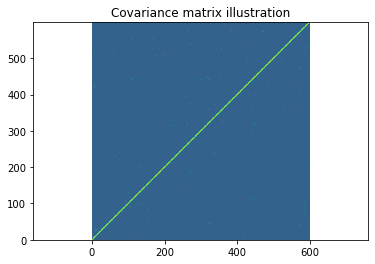

In [37]:
plt.contourf(covx)
plt.axis('equal')
plt.title('Covariance matrix illustration')

The eigenvalues ratio of x:

[0.01238062 0.01207247 0.01172112 0.01174801 0.01124544]


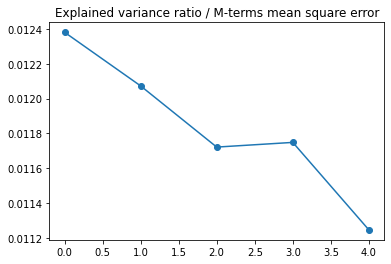

In [38]:
plt.plot(evalx[:5]/np.sum(evalx), '-o')
plt.title('Explained variance ratio / M-terms mean square error')
print(evalx[:5]/np.sum(evalx))

# Asymptotic Equivalence between OCT and KLT

The proof shows OCT and KLT should be equivalent when the block size $N$ is large (i.e., time range is wide). We will verify this experimentally.

Text(0.5, 1.0, 'OCT basis')

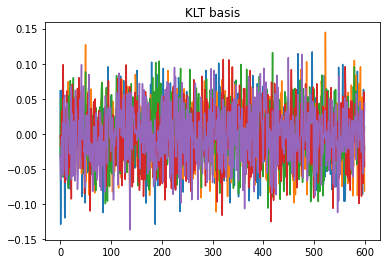

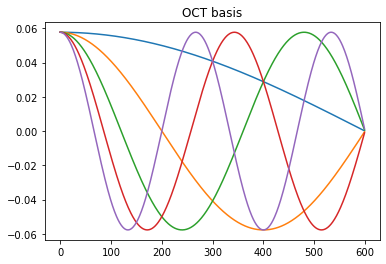

In [39]:
klt_basis = np.real(evecx.T) # each row is now an eigenvector
t = np.arange(length_of_trajs)/length_of_trajs
oct_basis = np.zeros(klt_basis.shape)
for i in range(klt_basis.shape[0]):
    oct_basis[i,:] = np.sqrt(2/(length_of_trajs)) * np.cos((i+0.5)*np.pi*t)
plt.figure()
for i in range(5):
    plt.plot(klt_basis[i,:])
plt.title('KLT basis')
plt.figure()
for i in range(5):
    plt.plot(oct_basis[i,:])
plt.title('OCT basis')

Let's approximate the average error when representing 100 trajectories in each basis: KLT and OCT

In [40]:
chosen_trajs = np.random.choice(num_of_trajs, size=100)
test_set = x_profiles[chosen_trajs,:]
klt_scores = test_set @ klt_basis.T
oct_scores = test_set @ oct_basis.T 

First we should check to make sure that the signal energy is well preserved in both basis.

In [41]:
signal_energy = np.sum(np.square(test_set), axis=1)
print('Max difference between KLT coeffs energy and signal energy: {}'.format(np.max(np.sum(np.square(klt_scores), axis=1) - np.sum(np.square(test_set), axis=1))))
print('Max difference between OCT coeffs energy and signal energy: {}'.format(np.max(np.sum(np.square(oct_scores), axis=1) - np.sum(np.square(test_set), axis=1))))

Max difference between KLT coeffs energy and signal energy: -0.39280253131954623
Max difference between OCT coeffs energy and signal energy: 0.9992525530337844


Next, we try to compare the average approximation error with 1, 2, 3, ... components allowed to represent.

In [42]:
representation_error_of_klt = np.ones((10,))
representation_error_of_oct = np.ones((10,))
for max_components_allowed in range(1,10):
    tail_of_signal_klt = test_set - klt_scores[:,:max_components_allowed] @ klt_basis[:max_components_allowed,:]
    energy_of_signal_tail_klt = np.sum(np.square(tail_of_signal_klt), axis=1)
    proportion_of_energy_klt = energy_of_signal_tail_klt / signal_energy
    representation_error_of_klt[max_components_allowed] = np.average(proportion_of_energy_klt)

    tail_of_signal_oct = test_set - oct_scores[:,:max_components_allowed] @ oct_basis[:max_components_allowed,:]
    energy_of_signal_tail_oct = np.sum(np.square(tail_of_signal_oct), axis=1)
    proportion_of_energy_oct = energy_of_signal_tail_oct / signal_energy
    representation_error_of_oct[max_components_allowed] = np.average(proportion_of_energy_oct)

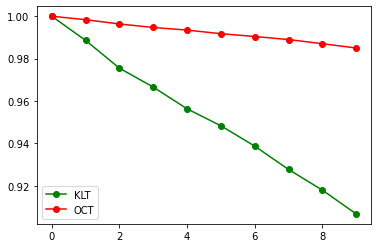

In [43]:
plt.plot(np.arange(0,10), representation_error_of_klt, 'g-o', label='KLT')
plt.plot(np.arange(0,10), representation_error_of_oct, 'r-o', label='OCT')
plt.legend()

In [44]:
representation_error_of_oct

array([1.        , 0.99837496, 0.99635224, 0.9946991 , 0.99345868,
       0.99176456, 0.99043596, 0.98899468, 0.98704037, 0.98500631])

In [45]:
representation_error_of_klt

array([1.        , 0.98859239, 0.97549358, 0.9665664 , 0.95629307,
       0.94829734, 0.93870178, 0.9276828 , 0.91792943, 0.906692  ])